<a href="https://colab.research.google.com/github/U-Aravindhakumar/Ad-Spend-Optimization/blob/main/ad%20main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Install and Import Necessary** **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# **2.** **Load and Preprocess the Dataset**

In [ ]:
# Load Dataset
df = pd.read_csv('/content/marketing_campaign_dataset.csv')

# Clean 'Acquisition_Cost': Remove $ and commas, convert to numeric
df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[\$,]', '', regex=True)
df['Acquisition_Cost'] = pd.to_numeric(df['Acquisition_Cost'], errors='coerce')

# Clean 'ROI': Remove %, convert to decimal
df['ROI'] = df['ROI'].replace('%', '', regex=True)
df['ROI'] = pd.to_numeric(df['ROI'], errors='coerce') / 100

# Convert 'Clicks' and 'Impressions' to numeric
df['Clicks'] = pd.to_numeric(df['Clicks'], errors='coerce')
df['Impressions'] = pd.to_numeric(df['Impressions'], errors='coerce')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop rows with missing values
df.dropna(inplace=True)


# 3. **Feature** **Engineering**

In [ ]:
# Calculate Click-Through Rate (CTR)
df['CTR'] = df['Clicks'] / df['Impressions']

# Calculate Cost Per Acquisition (CPA)
df['CPA'] = df['Acquisition_Cost'] / df['Clicks']

# Calculate Total Spend
df['Spend'] = df['Acquisition_Cost'] * df['Clicks']

# Calculate Revenue
df['Revenue'] = df['ROI'] * df['Spend']


# **4. Build and Evaluate Linear Regression Model**

In [ ]:
# Define Features and Target
X = df[['Spend']]
y = df['Revenue']

# Split into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on Test Set
y_pred = model.predict(X_test)

# Evaluate Model Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")



Model Performance:
RMSE: 140046.42
R² Score: 0.6908


# **5. Optimize Budget Allocation Using SLSQP**

In [ ]:
# Group Data by Channel for Optimization
channel_groups = df.groupby('Channel_Used').agg({
    'Spend': 'sum',
    'Revenue': 'sum'
}).reset_index()

X_channel = channel_groups[['Spend']]
y_channel = channel_groups['Revenue']

# Train Model on Aggregated Data
model_channel = LinearRegression()
model_channel.fit(X_channel, y_channel)

# Total Budget
total_budget = 100000  # Example budget

# Define Objective: Maximize Total ROI (Minimize Negative ROI)
def objective(spend_allocations):
    spend_allocations = np.array(spend_allocations).reshape(-1, 1)
    predicted_revenue = model_channel.predict(spend_allocations).sum()
    roi = predicted_revenue / spend_allocations.sum()
    return -roi  # Negative ROI for minimization

# Constraint: Total Spend = Total Budget
def constraint(spend_allocations):
    return spend_allocations.sum() - total_budget

# Initial Guess: Equal Allocation
initial_guess = np.array([total_budget / len(channel_groups)] * len(channel_groups))

# Bounds for Each Channel's Spend
bounds = [(0, total_budget) for _ in range(len(channel_groups))]

# Run Optimization
result = minimize(
    objective,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints={'type': 'eq', 'fun': constraint},
    options={'disp': True}
)

# Add Optimal Spend to DataFrame
channel_groups['Optimal_Spend'] = result.x

# Show Optimal Spend by Channel
print("\nOptimal Spend Allocation Across Channels:")
print(channel_groups[['Channel_Used', 'Optimal_Spend']])


NameError: name 'df' is not defined

# **6. Visualize Optimal Budget Allocation Across Channels**

In [ ]:
# Aggregate Optimal Spend by Channel
channel_spend = df.groupby('Channel_Used')['Optimal_Spend'].sum().reset_index()

# Plot Optimal Spend by Channel
plt.figure(figsize=(12, 6))
sns.barplot(data=channel_spend, x='Channel_Used', y='Optimal_Spend', palette='viridis')
plt.xlabel('Marketing Channel')
plt.ylabel('Optimal Spend')
plt.title('Optimal Budget Allocation Across Marketing Channels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Analyze ROI by Month**

In [ ]:
# Extract Month from Date
df['Month'] = df['Date'].dt.month

# Calculate Average ROI by Month
monthly_roi = df.groupby('Month')['ROI'].mean().reset_index()

# Plot Average ROI by Month
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_roi, x='Month', y='ROI', marker='o')
plt.xlabel('Month')
plt.ylabel('Average ROI')
plt.title('Average ROI by Month')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


# **8. Analyze ROI by Target Audience**

In [ ]:
# Calculate Average ROI by Target Audience
audience_roi = df.groupby('Target_Audience')['ROI'].mean().reset_index()

# Plot Average ROI by Target Audience
plt.figure(figsize=(12, 6))
sns.barplot(data=audience_roi, x='Target_Audience', y='ROI', palette='coolwarm')
plt.xlabel('Target Audience')
plt.ylabel('Average ROI')
plt.title('Average ROI by Target Audience')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **9. Identify Top Channels Based on Optimal Spend**

In [ ]:
# Sort Channels by Optimal Spend
top_channels = channel_spend.sort_values(by='Optimal_Spend', ascending=False)

# Display Top 5 Channels
print("\nTop 5 Marketing Channels by Optimal Spend:")
print(top_channels.head(5))


  Channel_Used        Spend      Revenue
0     LinkedIn  4802.857226  6303.249455
1      Twitter  3387.400632  3767.070410
2    Instagram  2836.995568  2932.307350
3    Instagram  1082.337977  1600.709569
4     LinkedIn  4754.210836  3805.960361
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.4629998626244918
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1

Optimal Spend Allocation Across Channels:
  Channel_Used  Optimal_Spend
0     Facebook        20000.0
1       Google        20000.0
2    Instagram        20000.0
3     LinkedIn        20000.0
4      Twitter        20000.0


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/

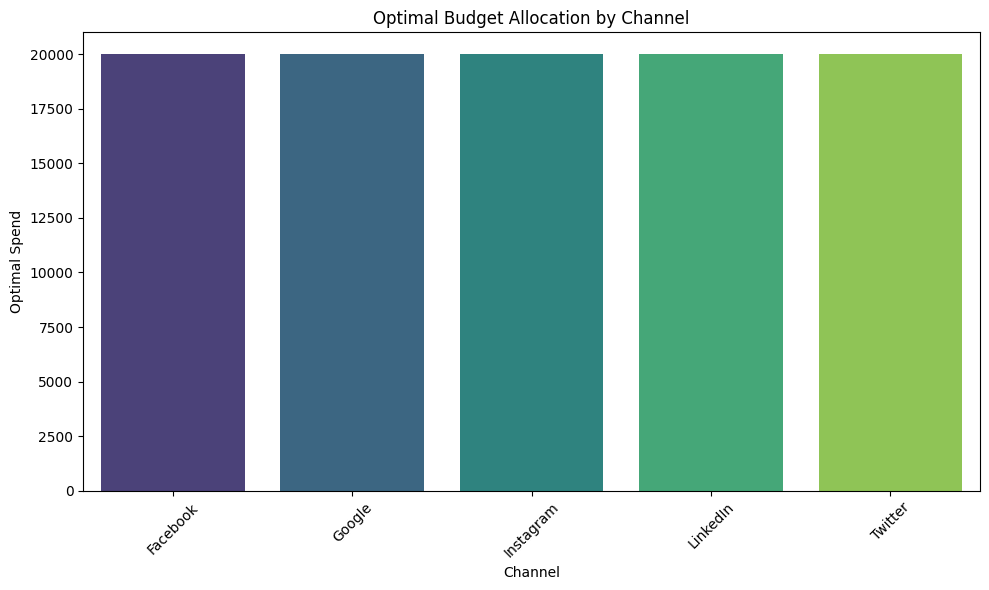

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Generate Sample Data
np.random.seed(42)
channels = ['Facebook', 'Google', 'Instagram', 'LinkedIn', 'Twitter']
n_channels = len(channels)

data = []
for _ in range(100):  # 100 rows
    channel = np.random.choice(channels)
    spend = np.random.uniform(1000, 5000)
    revenue = spend * np.random.uniform(0.8, 1.5)  # Random ROI
    data.append({'Channel_Used': channel, 'Spend': spend, 'Revenue': revenue})

df = pd.DataFrame(data)
print(df.head())

# 2️⃣ Group Data by Channel
channel_groups = df.groupby('Channel_Used').agg({
    'Spend': 'sum',
    'Revenue': 'sum'
}).reset_index()

X_channel = channel_groups[['Spend']]
y_channel = channel_groups['Revenue']

# 3️⃣ Train Linear Model on Aggregated Data
model_channel = LinearRegression()
model_channel.fit(X_channel, y_channel)

# 4️⃣ Set Total Budget
total_budget = 100000  # Example total budget

# 5️⃣ Define Objective Function (Maximize ROI)
def objective(spend_allocations):
    spend_allocations = np.array(spend_allocations).reshape(-1, 1)
    predicted_revenue = model_channel.predict(spend_allocations).sum()
    roi = predicted_revenue / spend_allocations.sum()
    return -roi  # Negative ROI for minimization

# 6️⃣ Constraint: Total Spend = Budget
def constraint(spend_allocations):
    return spend_allocations.sum() - total_budget

# 7️⃣ Initial Guess: Equal Allocation
initial_guess = np.array([total_budget / n_channels] * n_channels)

# 8️⃣ Bounds for Spend per Channel
bounds = [(0, total_budget) for _ in range(n_channels)]

# 9️⃣ Run Optimization
result = minimize(
    objective,
    initial_guess,
    method='SLSQP',
    bounds=bounds,
    constraints={'type': 'eq', 'fun': constraint},
    options={'disp': True}
)

# 1️⃣0️⃣ Add Optimal Spend to Channel Data
channel_groups['Optimal_Spend'] = result.x

# 1️⃣1️⃣ Show Results
print("\nOptimal Spend Allocation Across Channels:")
print(channel_groups[['Channel_Used', 'Optimal_Spend']])

# 1️⃣2️⃣ Plot Optimal Budget
plt.figure(figsize=(10, 6))
sns.barplot(data=channel_groups, x='Channel_Used', y='Optimal_Spend', palette='viridis')
plt.title('Optimal Budget Allocation by Channel')
plt.xlabel('Channel')
plt.ylabel('Optimal Spend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


R² Score: -0.03212000824398609
RMSE: 1.763084942802388


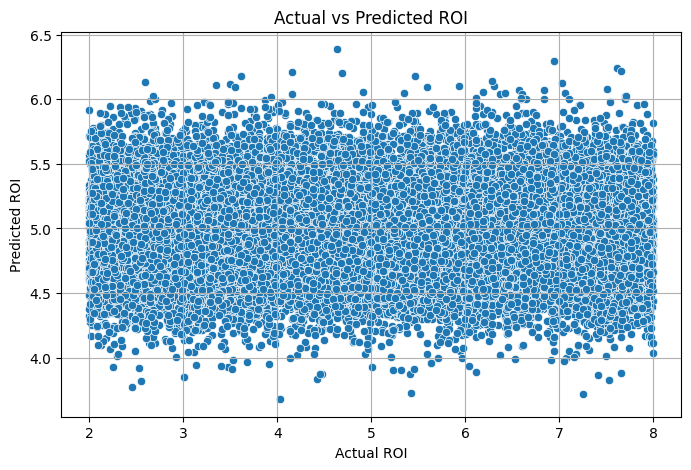

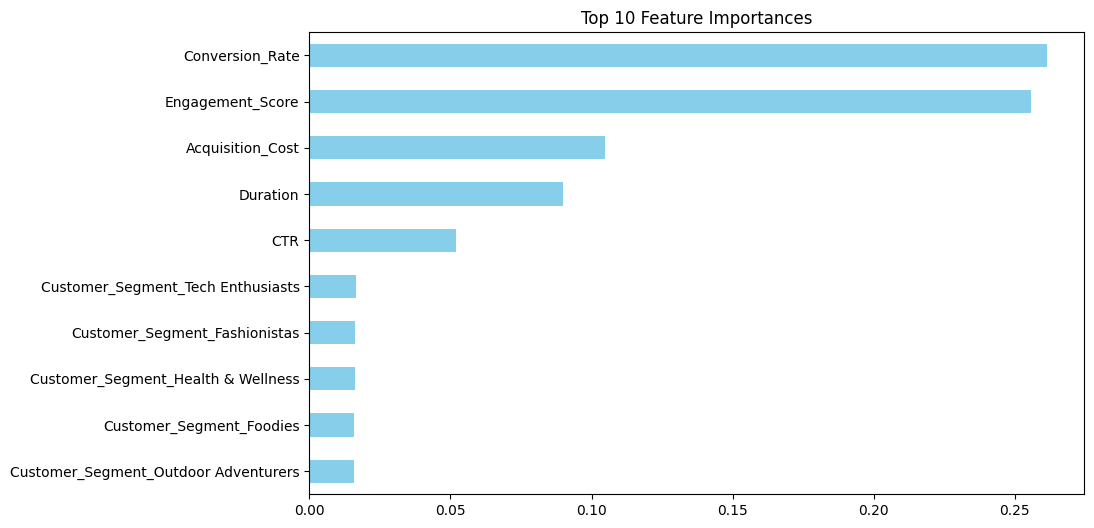

In [ ]:
# ✅ 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# ✅ 2. Load Dataset (Upload in Colab)
df = pd.read_csv('/content/marketing_campaign_dataset.csv')

# ✅ 3. Data Cleaning & Feature Engineering
df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[\$,]', '', regex=True).astype(float)
df['Duration'] = df['Duration'].str.extract('(\d+)').astype(int)
df['CTR'] = df['Clicks'] / df['Impressions']
df['Date'] = pd.to_datetime(df['Date'])

# ✅ 4. Drop rows with missing target (ROI)
df = df.dropna(subset=['ROI'])

# ✅ 5. Feature Selection
features = ['Channel_Used', 'Target_Audience', 'Customer_Segment', 'Duration',
            'Acquisition_Cost', 'Conversion_Rate', 'CTR', 'Engagement_Score']
X = df[features]
y = df['ROI']

# ✅ 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 7. Preprocessing and Modeling Pipeline
categorical_cols = ['Channel_Used', 'Target_Audience', 'Customer_Segment']
numerical_cols = list(set(features) - set(categorical_cols))

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# ✅ 8. Train Model
model.fit(X_train, y_train)

# ✅ 9. Evaluate Model
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# ✅ 10. ROI Prediction Plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual ROI")
plt.ylabel("Predicted ROI")
plt.title("Actual vs Predicted ROI")
plt.grid(True)
plt.show()

# ✅ 11. Feature Importance (optional)
rf_model = model.named_steps['regressor']
encoded_features = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
all_features = list(encoded_features) + numerical_cols
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

# Plot Top Feature Importances
plt.figure(figsize=(10,6))
feat_imp.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()


Saving marketing_campaign_dataset.csv to marketing_campaign_dataset.csv
Columns:
 Index(['Campaign_ID', 'Company', 'Campaign_Type', 'Target_Audience',
       'Duration', 'Channel_Used', 'Conversion_Rate', 'Acquisition_Cost',
       'ROI', 'Location', 'Language', 'Clicks', 'Impressions',
       'Engagement_Score', 'Customer_Segment', 'Date'],
      dtype='object')
Missing values:
 Campaign_ID         0
Company             0
Campaign_Type       0
Target_Audience     0
Duration            0
Channel_Used        0
Conversion_Rate     0
Acquisition_Cost    0
ROI                 0
Location            0
Language            0
Clicks              0
Impressions         0
Engagement_Score    0
Customer_Segment    0
Date                0
dtype: int64
R² Score: -0.03212000824398609
RMSE: 1.763084942802388


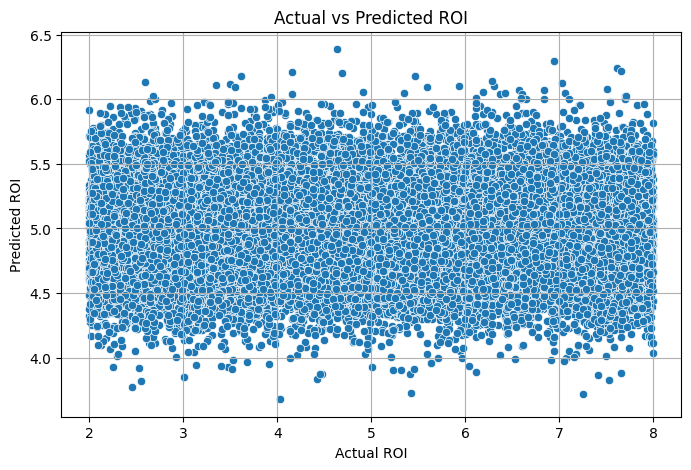

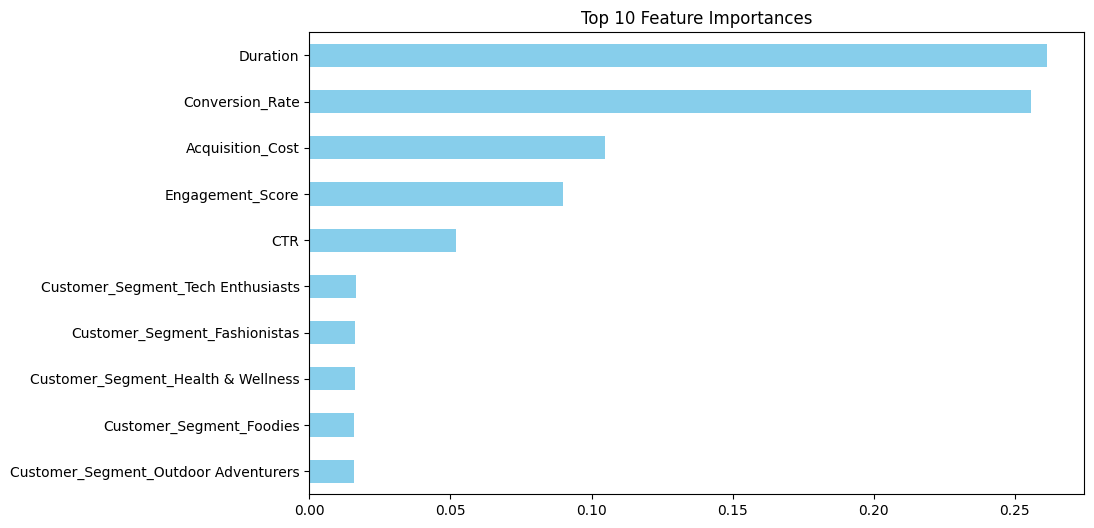

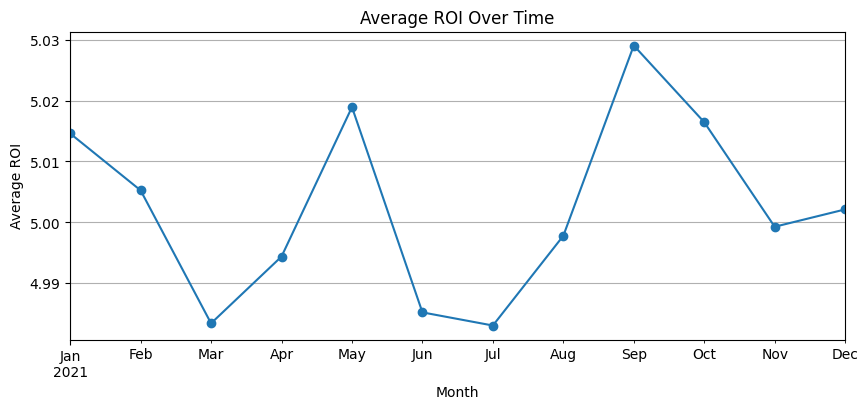

In [ ]:
# ✅ 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# ✅ 2. Upload CSV file (marketing_campaign_dataset.csv)
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))

# ✅ 3. Inspect and Clean Data
print("Columns:\n", df.columns)
print("Missing values:\n", df.isnull().sum())

# 👉 Convert columns to appropriate types
if 'Acquisition_Cost' in df.columns:
    df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[\$,]', '', regex=True).astype(float)

if 'Duration' in df.columns:
    df['Duration'] = df['Duration'].str.extract('(\d+)').astype(float)

# 👉 Handle CTR if Clicks and Impressions exist
if 'Clicks' in df.columns and 'Impressions' in df.columns:
    df['CTR'] = df['Clicks'] / df['Impressions']

# 👉 Convert Date column
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# ✅ 4. Drop rows with missing target (ROI)
df = df.dropna(subset=['ROI'])

# ✅ 5. Feature and Target Selection
features = ['Channel_Used', 'Target_Audience', 'Customer_Segment', 'Duration',
            'Acquisition_Cost', 'Conversion_Rate', 'CTR', 'Engagement_Score']
features = [col for col in features if col in df.columns]  # only keep available columns

X = df[features]
y = df['ROI']

# ✅ 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 7. Preprocessing and Model Pipeline
categorical_cols = [col for col in ['Channel_Used', 'Target_Audience', 'Customer_Segment'] if col in df.columns]
numerical_cols = list(set(features) - set(categorical_cols))

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# ✅ 8. Train Model
model.fit(X_train, y_train)

# ✅ 9. Evaluate Model
y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# ✅ 10. Actual vs Predicted ROI Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual ROI")
plt.ylabel("Predicted ROI")
plt.title("Actual vs Predicted ROI")
plt.grid(True)
plt.show()

# ✅ 11. Feature Importances
rf_model = model.named_steps['regressor']
encoded_features = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
all_features = list(encoded_features) + numerical_cols
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

# ✅ 12. Optional: ROI Trend Over Time
if 'Date' in df.columns:
    roi_trend = df.groupby(df['Date'].dt.to_period('M'))['ROI'].mean()
    roi_trend.plot(kind='line', marker='o', figsize=(10, 4))
    plt.title("Average ROI Over Time")
    plt.xlabel("Month")
    plt.ylabel("Average ROI")
    plt.grid(True)
    plt.show()


# Average ROI per channel
channel_roi = df.groupby('Channel_Used')['ROI'].mean().sort_values(ascending=False)
print(channel_roi)
channel_roi.plot(kind='bar', title="Average ROI by Channel", color='lightgreen')
plt.ylabel("ROI")
plt.grid(True)
plt.show()


if 'Date' in df.columns:
    df['Month'] = df['Date'].dt.month
    monthly_roi = df.groupby('Month')['ROI'].mean()
    print(monthly_roi)

    monthly_roi.plot(kind='bar', title="Average ROI by Month", color='orange')
    plt.xlabel("Month")
    plt.ylabel("Average ROI")
    plt.grid(True)
    plt.show()

if 'Customer_Segment' in df.columns:
    seg_roi = df.groupby('Customer_Segment')['ROI'].mean().sort_values(ascending=False)
    print(seg_roi)

    seg_roi.plot(kind='bar', title="ROI by Customer Segment", color='cyan')
    plt.ylabel("ROI")
    plt.grid(True)
    plt.show()



Saving marketing_campaign_dataset.csv to marketing_campaign_dataset.csv

 Model Evaluation
R² Score: -0.03212000824398609
RMSE: 1.763084942802388


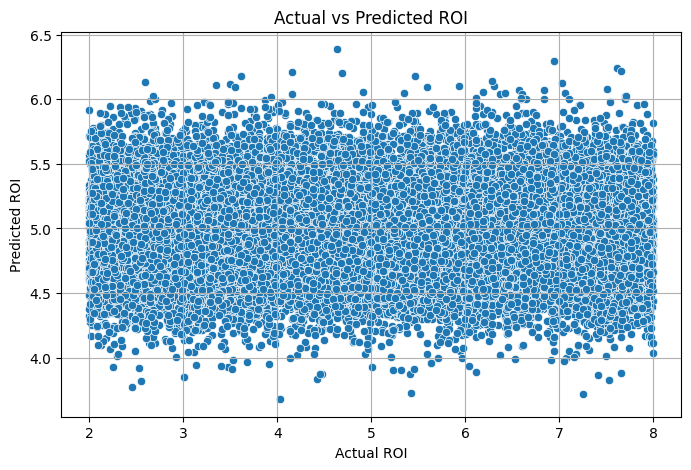

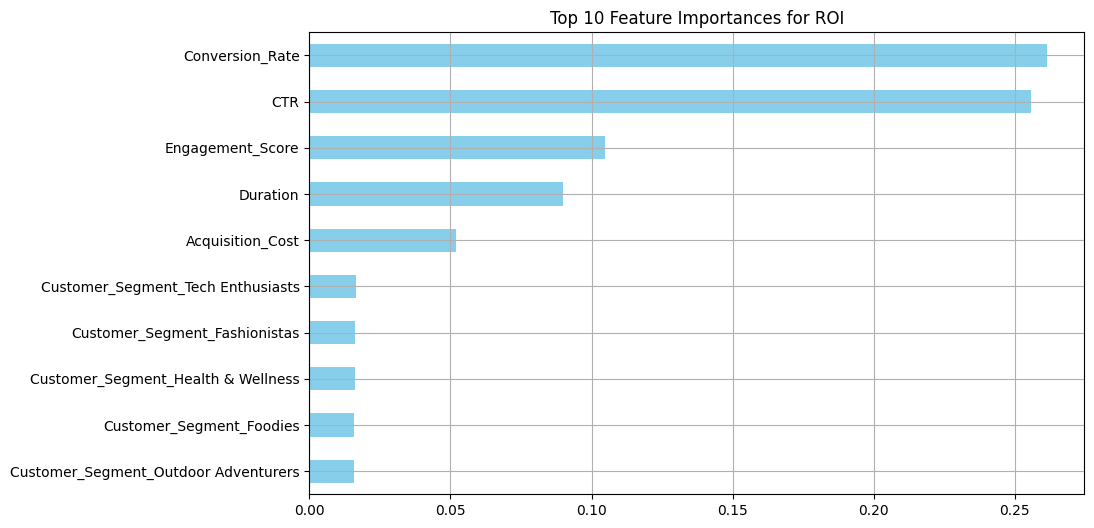

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


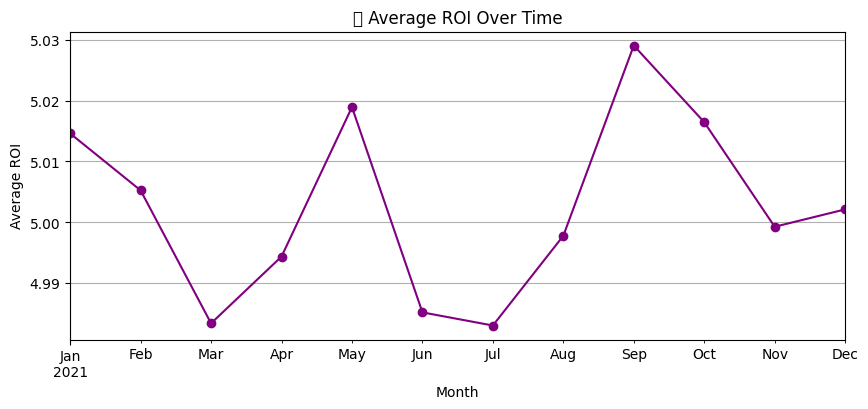


📊 Average ROI by Channel:
Channel_Used
Facebook      5.018699
Website       5.014167
Google Ads    5.003141
Email         4.996487
YouTube       4.993754
Instagram     4.988706
Name: ROI, dtype: float64


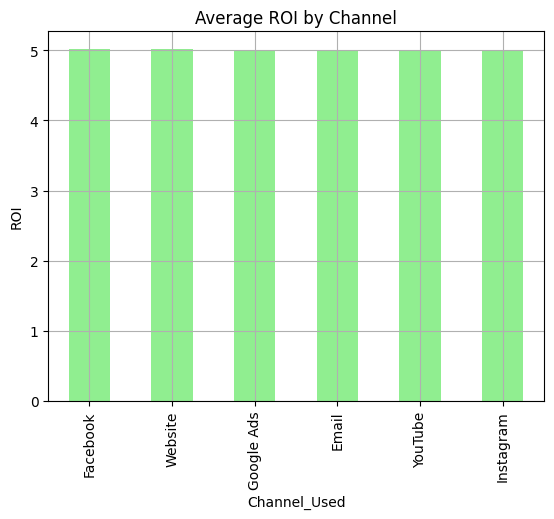


 Average ROI by Month:
Month
1     5.014595
2     5.005248
3     4.983404
4     4.994372
5     5.018923
6     4.985203
7     4.983045
8     4.997793
9     5.029044
10    5.016445
11    4.999271
12    5.002122
Name: ROI, dtype: float64


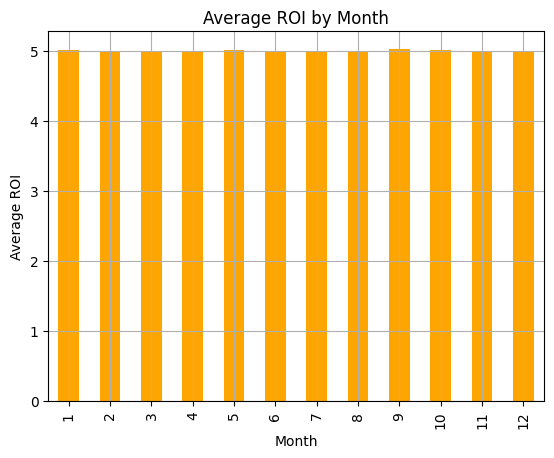


 Best day to post the Ad
Day
Thursday     5.024529
Saturday     5.012152
Wednesday    5.005307
Sunday       5.000545
Friday       4.997064
Tuesday      4.993287
Monday       4.984285
Name: ROI, dtype: float64

👥 Average ROI by Customer Segment:
Customer_Segment
Foodies                5.004376
Tech Enthusiasts       5.004234
Health & Wellness      5.003202
Fashionistas           5.000962
Outdoor Adventurers    4.999393
Name: ROI, dtype: float64


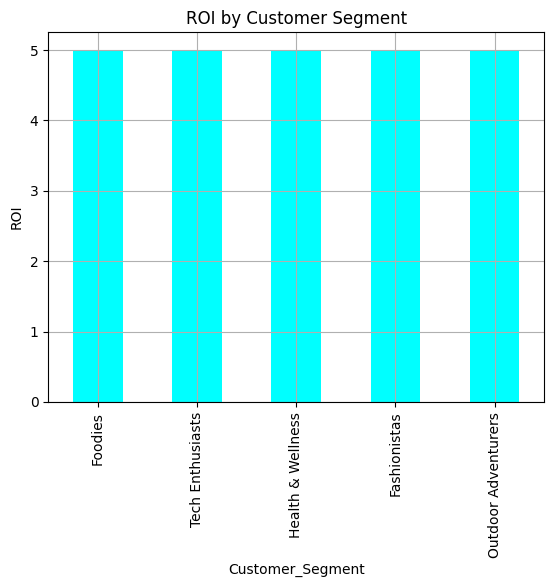


 Best Ad Duration
Duration_Group
15-30s    5.008887
30-60s    5.002043
<15s      4.996720
1-2min         NaN
2min+          NaN
Name: ROI, dtype: float64


<ipython-input-2-fc70359e909c>:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_roi = df.groupby('Duration_Group')['ROI'].mean().sort_values(ascending=False)
<ipython-input-2-fc70359e909c>:163: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=duration_roi.index, y=duration_roi.values, palette="coolwarm")


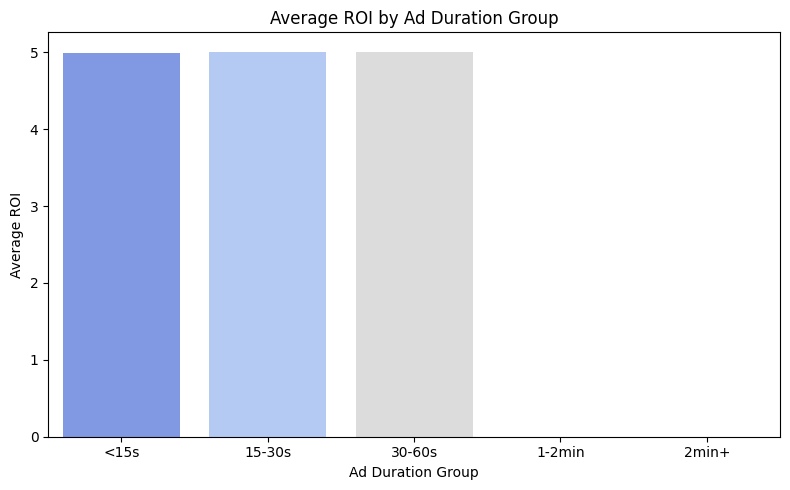

In [ ]:
# ✅ 1. Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# ✅ 2. Upload CSV file (marketing_campaign_dataset.csv)
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded)))


# Data Cleaning
#Convert columns to appropriate types
if 'Acquisition_Cost' in df.columns:
    df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[\$,]', '', regex=True).astype(float)

if 'Duration' in df.columns:
    df['Duration'] = df['Duration'].astype(str).str.extract('(\d+)').astype(float)

# Handle CTR if Clicks and Impressions exist
if 'Clicks' in df.columns and 'Impressions' in df.columns:
    df['CTR'] = df['Clicks'] / df['Impressions']

# Convert Date column
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# Convert Date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Hour'] = df['Date'].dt.hour
df['Day'] = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month

# 4. Drop rows with missing target (ROI)
df = df.dropna(subset=['ROI'])

# 5. Feature and Target Selection
features = ['Channel_Used', 'Target_Audience', 'Customer_Segment', 'Duration',
            'Acquisition_Cost', 'Conversion_Rate', 'CTR', 'Engagement_Score']
features = [col for col in features if col in df.columns]  # Only keep columns that exist

X = df[features]
y = df['ROI']

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Preprocessing and Model Pipeline
categorical_cols = [col for col in ['Channel_Used', 'Target_Audience', 'Customer_Segment'] if col in X.columns]
numerical_cols = list(set(features) - set(categorical_cols))

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 8. Train Model
model.fit(X_train, y_train)

# 9. Evaluate Model
y_pred = model.predict(X_test)
print("\n Model Evaluation")
print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# 10. Actual vs Predicted ROI Plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual ROI")
plt.ylabel("Predicted ROI")
plt.title("Actual vs Predicted ROI")
plt.grid(True)
plt.show()

# 11. Feature Importances
rf_model = model.named_steps['regressor']
encoded_features = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(categorical_cols)
all_features = list(encoded_features) + numerical_cols
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
feat_imp.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Feature Importances for ROI")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# 12. ROI Trend Over Time
if 'Date' in df.columns:
    roi_trend = df.groupby(df['Date'].dt.to_period('M'))['ROI'].mean()
    roi_trend.plot(kind='line', marker='o', figsize=(10, 4), color='purple')
    plt.title("📈 Average ROI Over Time")
    plt.xlabel("Month")
    plt.ylabel("Average ROI")
    plt.grid(True)
    plt.show()

# 13. Best Performing Ad Channel
if 'Channel_Used' in df.columns:
    print("\n📊 Average ROI by Channel:")
    channel_roi = df.groupby('Channel_Used')['ROI'].mean().sort_values(ascending=False)
    print(channel_roi)

    channel_roi.plot(kind='bar', title="Average ROI by Channel", color='lightgreen')
    plt.ylabel("ROI")
    plt.grid(True)
    plt.show()

# 14. Best Month to Run Ads
if 'Date' in df.columns:
    df['Month'] = df['Date'].dt.month
    monthly_roi = df.groupby('Month')['ROI'].mean()
    print("\n Average ROI by Month:")
    print(monthly_roi)

    monthly_roi.plot(kind='bar', title="Average ROI by Month", color='orange')
    plt.xlabel("Month")
    plt.ylabel("Average ROI")
    plt.grid(True)
    plt.show()


# Best Day or Month
daily_roi = df.groupby('Day')['ROI'].mean().sort_values(ascending=False)
monthly_roi = df.groupby('Month')['ROI'].mean().sort_values(ascending=False)
print("\n Best day to post the Ad")
print(daily_roi)


# 15. Best Customer Segment
if 'Customer_Segment' in df.columns:
    seg_roi = df.groupby('Customer_Segment')['ROI'].mean().sort_values(ascending=False)
    print("\n👥 Average ROI by Customer Segment:")
    print(seg_roi)

    seg_roi.plot(kind='bar', title="ROI by Customer Segment", color='cyan')
    plt.ylabel("ROI")
    plt.grid(True)
    plt.show()

# 16
if 'Duration' in df.columns:
    df['Duration_Group'] = pd.cut(df['Duration'], bins=[0, 15, 30, 60, 120, float('inf')],
                                  labels=['<15s', '15-30s', '30-60s', '1-2min', '2min+'])
    duration_roi = df.groupby('Duration_Group')['ROI'].mean().sort_values(ascending=False)
    print("\n Best Ad Duration")
    print(duration_roi)

# Visualization: ROI by Duration Group
plt.figure(figsize=(8, 5))
sns.barplot(x=duration_roi.index, y=duration_roi.values, palette="coolwarm")
plt.title("Average ROI by Ad Duration Group")
plt.xlabel("Ad Duration Group")
plt.ylabel("Average ROI")
plt.tight_layout()
plt.show()





In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# 1. Load & preprocess exactly as before
df = pd.read_csv("marketing_campaign_dataset.csv")

# Clean and feature‐engineer
df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[\$,]', '', regex=True).astype(float)
df['Duration'] = df['Duration'].astype(str).str.extract('(\d+)').astype(float)
df['CTR'] = df['Clicks'] / df['Impressions']
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Hour'] = df['Date'].dt.hour
df['Day']  = df['Date'].dt.day_name()
df['Month'] = df['Date'].dt.month

# Drop missing ROI
df = df.dropna(subset=['ROI'])

# 2. (Re)create each chart, saving to PNG:

# ‣ a) Actual vs Predicted ROI
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Prepare features/target exactly as before
features = ['Channel_Used','Target_Audience','Customer_Segment','Duration',
            'Acquisition_Cost','Conversion_Rate','CTR','Engagement_Score']
features = [c for c in features if c in df.columns]
X = df[features]
y = df['ROI']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)
cat_cols = [c for c in ['Channel_Used','Target_Audience','Customer_Segment'] if c in X.columns]
num_cols = list(set(features) - set(cat_cols))

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

pipeline = Pipeline([
    ('prep', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, s=20, alpha=0.6)
plt.xlabel("Actual ROI")
plt.ylabel("Predicted ROI")
plt.title("Actual vs Predicted ROI")
plt.grid(True)
plt.tight_layout()
plt.savefig("actual_vs_predicted_ROI.png")
plt.close()

# ‣ b) Feature Importances (top 10)
rf = pipeline.named_steps['rf']
encoded_feats = pipeline.named_steps['prep']\
                  .transformers_[0][1]\
                  .get_feature_names_out(cat_cols)
all_feats = list(encoded_feats) + num_cols
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=all_feats).sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
feat_imp.plot(kind='barh', color='skyblue')
plt.title("Top 10 Feature Importances for ROI")
plt.gca().invert_yaxis()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("feature_importances.png")
plt.close()

# ‣ c) ROI Trend Over Time (Monthly)
roi_trend = df.groupby(df['Date'].dt.to_period('M'))['ROI'].mean()
plt.figure(figsize=(8,4))
roi_trend.plot(kind='line', marker='o', color='purple')
plt.title("Average ROI Over Time")
plt.xlabel("Month")
plt.ylabel("Average ROI")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("roi_over_time.png")
plt.close()

# ‣ d) Average ROI by Channel
channel_roi = df.groupby('Channel_Used')['ROI'].mean().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=channel_roi.index, y=channel_roi.values, palette="Greens_d")
plt.title("Average ROI by Channel")
plt.xlabel("Channel Used")
plt.ylabel("ROI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("roi_by_channel.png")
plt.close()

# ‣ e) Average ROI by Month
monthly_roi = df.groupby('Month')['ROI'].mean().sort_index()
plt.figure(figsize=(8,5))
sns.barplot(x=monthly_roi.index.astype(str), y=monthly_roi.values, palette="Oranges_d")
plt.title("Average ROI by Month")
plt.xlabel("Month")
plt.ylabel("ROI")
plt.tight_layout()
plt.savefig("roi_by_month.png")
plt.close()

# ‣ f) Best Day to Post Ad (Average ROI by Day)
daily_roi = df.groupby('Day')['ROI'].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
plt.figure(figsize=(8,5))
sns.barplot(x=daily_roi.index, y=daily_roi.values, palette="Blues_d")
plt.title("Average ROI by Day of the Week")
plt.xlabel("Day")
plt.ylabel("ROI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("roi_by_day.png")
plt.close()

# ‣ g) ROI by Customer Segment
if 'Customer_Segment' in df.columns:
    seg_roi = df.groupby('Customer_Segment')['ROI'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x=seg_roi.index, y=seg_roi.values, palette="Purples_d")
    plt.title("Average ROI by Customer Segment")
    plt.xlabel("Customer Segment")
    plt.ylabel("ROI")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("roi_by_segment.png")
    plt.close()

# ‣ h) ROI by Ad Duration Group
if 'Duration' in df.columns:
    df['Duration_Group'] = pd.cut(df['Duration'],
                                  bins=[0,15,30,60,120, float('inf')],
                                  labels=['<15s','15-30s','30-60s','1-2min','2min+'])
    dur_roi = df.groupby('Duration_Group')['ROI'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x=dur_roi.index, y=dur_roi.values, palette="coolwarm")
    plt.title("Average ROI by Ad Duration Group")
    plt.xlabel("Ad Duration Group")
    plt.ylabel("ROI")
    plt.tight_layout()
    plt.savefig("roi_by_duration.png")
    plt.close()

# 3. Download all PNGs at once (Colab)
files.download("actual_vs_predicted_ROI.png")
files.download("feature_importances.png")
files.download("roi_over_time.png")
files.download("roi_by_channel.png")
files.download("roi_by_month.png")
files.download("roi_by_day.png")
files.download("roi_by_segment.png")
files.download("roi_by_duration.png")


<ipython-input-4-cfb02c99675b>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_roi.index, y=channel_roi.values, palette="Greens_d")
<ipython-input-4-cfb02c99675b>:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_roi.index.astype(str), y=monthly_roi.values, palette="Oranges_d")
<ipython-input-4-cfb02c99675b>:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=daily_roi.index, y=daily_roi.values, palette="Blues_d")
<ipython-input-4-cfb02c99675b>:137: FutureWarning: 

Passing `palette` without assigning `hue` is depreca

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>